In [1]:
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from padtools import neon_betas

In [2]:
exp = pd.read_excel('Data/exp_gauss3.xlsx', sheet_name='fitted').set_index('dataset')
exp = exp[[k for k in exp if k.startswith("ne_") and k.endswith("_value")]]
exp = pd.concat(
    [
        exp,
        pd.read_excel('Data/Experimental intensity ratio and beta amplitude scale factor.xlsx', sheet_name='Best fit')
        .set_index('Dataset')['Amp scale factor'],
    ],
    axis=1,
)
exp['Photon (eV)'] = pd.Series({'good1': 15.9, 'good2': 14.3, 'good3': 19.1, 'good4': 15.9})
exp

,ne_beta1_amp_value,ne_beta1_freq_value,ne_beta1_offset_value,ne_beta1_shift_value,ne_beta1m3_amp_value,ne_beta1m3_freq_value,ne_beta1m3_offset_value,ne_beta1m3_shift_value,ne_beta2_c_value,ne_beta3_amp_value,ne_beta3_freq_value,ne_beta3_offset_value,ne_beta3_shift_value,ne_beta4_c_value,Amp scale factor,Photon (eV)
good1,0.280043,6.283185,-0.017148,0.478739,0.414468,6.283185,0.041710,2.530990,0.346753,0.398722,6.283185,-0.039238,-0.182652,0.432741,0.360079,15.9
good2,0.267432,6.283185,-0.045379,0.485390,0.410269,6.283185,-0.026827,1.288083,-0.087931,0.197069,6.283185,-0.012368,-1.145020,-0.030674,0.262322,14.3
good3,0.372453,6.283185,-0.021204,5.661447,0.274549,6.283185,0.034132,6.968905,0.884406,0.267384,6.283185,-0.036890,4.939388,0.024581,0.316547,19.1
good4,0.152872,6.283185,-0.030159,4.816525,0.244540,6.283185,0.006910,6.944638,0.480629,0.233538,6.283185,-0.024713,4.182441,0.095546,0.226153,15.9


In [3]:
the = pd.read_excel('Data/Simulated Ne beta parameters, TDHF, 2018-09-17.xlsx', sheet_name='Reduced').set_index('Target dataset')
the

,Photon (eV),Int_w (W/cm2),Int_2w (W/cm2),Int ratio,Ref int ratio,coeff_sp,eta_sp,coeff_psp,eta_psp,coeff_pdp,eta_pdp,coeff_dp,eta_dp,coeff_fdp,eta_fdp
Target dataset,,,,,,,,,,,,,,,
good1,15.9,10000000000000,2200000000,4.690416e-09,1.118034e-08,-0.032928,2.111679,-0.091220,1.208117,-0.267272,-2.274385,0.088829,0,0.374939,1.204615
good2,14.3,10000000000000,1540000000,3.924283e-09,1.166190e-08,-0.033212,2.338519,-0.021980,-0.313510,-0.301771,-2.329838,0.079465,0,0.452605,1.162043
good3,19.1,10000000000000,1490000000,3.860052e-09,1.048809e-08,-0.019186,1.805942,-0.052107,-1.935585,-0.037863,2.450947,0.060879,0,0.283481,1.265858
good4,15.9,10000000000000,4870000000,6.978539e-09,1.118034e-08,-0.048936,2.111979,-0.091223,1.207330,-0.267308,-2.274041,0.131952,0,0.374471,1.203681


In [4]:
def b_to_beta(b0, b1_amp, b1_shift, b2, b3_amp, b3_shift, b4, b1m3_amp, b1m3_shift):
    return {
        'beta1_amp': b1_amp / b0,
        'beta1_shift': b1_shift,
        'beta2': b2 / b0,
        'beta3_amp': b3_amp / b0,
        'beta3_shift': b3_shift,
        'beta4': b4 / b0,
        'beta1m3_amp': b1m3_amp / b0,
        'beta1m3_shift': b1m3_shift,
    }


def rescale(d, r):
    relr = r / d['Int ratio'] * d['Ref int ratio']
    ret = neon_betas(**{
        **{k: v for k, v in d.items() if k.startswith('coeff_') or k.startswith('eta_')},
        'coeff_sp': d['coeff_sp'] * relr,
        'coeff_dp': d['coeff_dp'] * relr,
    })
    return b_to_beta(**ret)


r = np.linspace(0, 20, 2001)[1:]
rescaled = {
    k: pd.DataFrame({'Rel int ratio': r, **rescale(d, r)}).set_index('Rel int ratio')
    for k, d in the.iterrows()
}

In [5]:
restructed = {
    k: rescale(d, d['Int ratio'] / d['Ref int ratio'])
    for k, d in the.iterrows()
}
for dataset, d in restructed.items():
    print(f"{dataset}:")
    for k, v in d.items():
        print(f"    {k:13}: {v: .3f}")

good1:
    beta1_amp    :  0.760
    beta1_shift  :  1.578
    beta2        : -0.172
    beta3_amp    :  0.959
    beta3_shift  :  0.820
    beta4        :  0.941
    beta1m3_amp  :  1.029
    beta1m3_shift: -2.855
good2:
    beta1_amp    :  0.532
    beta1_shift  :  1.783
    beta2        : -0.590
    beta3_amp    :  0.406
    beta3_shift  :  0.061
    beta4        :  0.221
    beta1m3_amp  :  0.867
    beta1m3_shift:  2.551
good3:
    beta1_amp    :  1.160
    beta1_shift  :  1.561
    beta2        :  0.613
    beta3_amp    :  0.479
    beta3_shift  :  0.298
    beta4        : -0.221
    beta1m3_amp  :  1.164
    beta1m3_shift:  2.189
good4:
    beta1_amp    :  0.785
    beta1_shift  :  1.577
    beta2        :  0.001
    beta3_amp    :  0.993
    beta3_shift  :  0.819
    beta4        :  0.656
    beta1m3_amp  :  1.067
    beta1m3_shift: -2.854


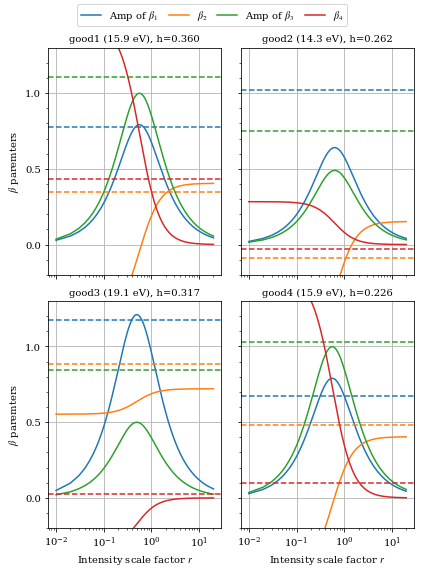

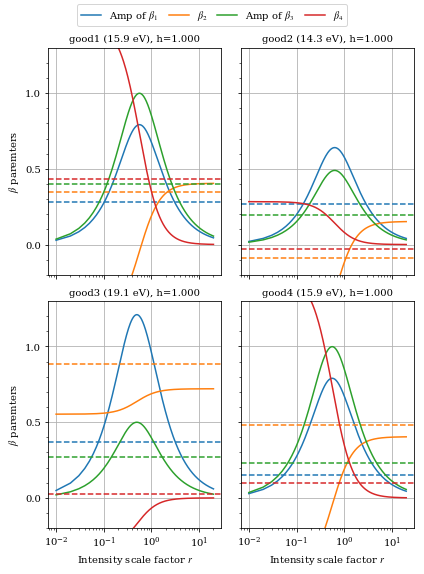

In [6]:
plt.style.use("Report.mplstyle")
plt.figure(figsize=(6, 8))
for i, dataset in enumerate(rescaled):
    ph = exp.loc[dataset, 'Photon (eV)']
    hh = exp.loc[dataset, 'Amp scale factor']
    plt.subplot(2, 2, i+1)
    plt.title(f"{dataset} ({ph} eV), h={hh:.3f}")
    plt.xlabel(r'Intensity scale factor $r$')
    plt.ylabel(r'$\beta$ paremters')
    for h, k, l, prop in zip(
            ['ne_beta1_amp_value', 'ne_beta2_c_value', 'ne_beta3_amp_value', 'ne_beta4_c_value'],
            ['beta1_amp', 'beta2', 'beta3_amp', 'beta4'],
            [r'Amp of $\beta_1$', r'$\beta_2$', r'Amp of $\beta_3$', r'$\beta_4$'],
            plt.rcParams['axes.prop_cycle'],
        ):
        sign, factor = 1, 1
        if k.endswith('_amp'):
            if all(v < 0 for v in rescaled[dataset][k]):
                sign = -1
            factor = hh
        plt.axhline(exp.loc[dataset, h] / factor, linestyle='dashed', **prop)
        plt.plot(sign * rescaled[dataset][k], label=l, **prop)
    plt.grid(True)
    plt.xscale('log')
    plt.ylim(-0.2, 1.3)
    plt.locator_params(axis='y', steps=[1, 5, 10])
    if i == 0:
        plt.figlegend(loc='upper center', ncol=4, columnspacing=1)
    plt.gca().label_outer()
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

plt.style.use("Report.mplstyle")
plt.figure(figsize=(6, 8))
for i, dataset in enumerate(rescaled):
    ph = exp.loc[dataset, 'Photon (eV)']
    hh = 1  # exp.loc[dataset, 'Amp scale factor']
    plt.subplot(2, 2, i+1)
    plt.title(f"{dataset} ({ph} eV), h={hh:.3f}")
    plt.xlabel(r'Intensity scale factor $r$')
    plt.ylabel(r'$\beta$ paremters')
    for h, k, l, prop in zip(
            ['ne_beta1_amp_value', 'ne_beta2_c_value', 'ne_beta3_amp_value', 'ne_beta4_c_value'],
            ['beta1_amp', 'beta2', 'beta3_amp', 'beta4'],
            [r'Amp of $\beta_1$', r'$\beta_2$', r'Amp of $\beta_3$', r'$\beta_4$'],
            plt.rcParams['axes.prop_cycle'],
        ):
        sign, factor = 1, 1
        if k.endswith('_amp'):
            if all(v < 0 for v in rescaled[dataset][k]):
                sign = -1
            factor = hh
        plt.axhline(exp.loc[dataset, h] / factor, linestyle='dashed', **prop)
        plt.plot(sign * rescaled[dataset][k], label=l, **prop)
    plt.grid(True)
    plt.xscale('log')
    plt.ylim(-0.2, 1.3)
    plt.locator_params(axis='y', steps=[1, 5, 10])
    if i == 0:
        plt.figlegend(loc='upper center', ncol=4, columnspacing=1)
    plt.gca().label_outer()
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

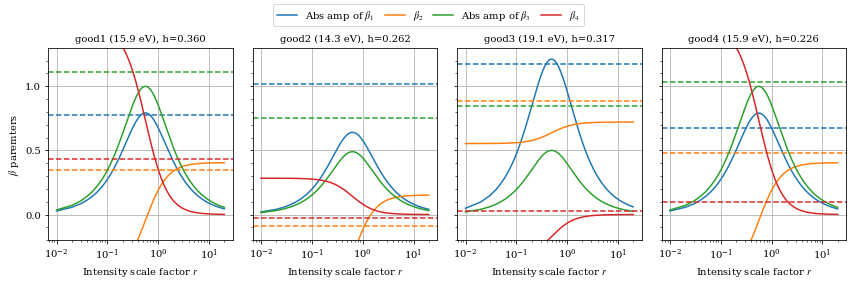

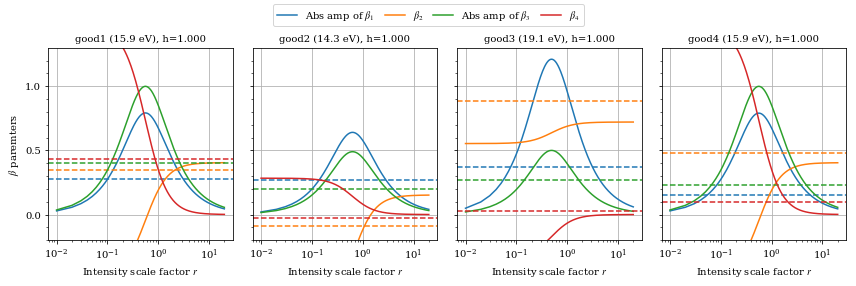

In [7]:
plt.style.use("Report.mplstyle")
plt.figure(figsize=(12, 4))
for i, dataset in enumerate(rescaled):
    ph = exp.loc[dataset, 'Photon (eV)']
    hh = exp.loc[dataset, 'Amp scale factor']
    plt.subplot(1, 4, i+1)
    plt.title(f"{dataset} ({ph} eV), h={hh:.3f}")
    plt.xlabel(r'Intensity scale factor $r$')
    plt.ylabel(r'$\beta$ paremters')
    for h, k, l, prop in zip(
            ['ne_beta1_amp_value', 'ne_beta2_c_value', 'ne_beta3_amp_value', 'ne_beta4_c_value'],
            ['beta1_amp', 'beta2', 'beta3_amp', 'beta4'],
            [r'Abs amp of $\beta_1$', r'$\beta_2$', r'Abs amp of $\beta_3$', r'$\beta_4$'],
            plt.rcParams['axes.prop_cycle'],
        ):
        sign, factor = 1, 1
        if k.endswith('_amp'):
            if all(v < 0 for v in rescaled[dataset][k]):
                sign = -1
            factor = hh
        plt.axhline(exp.loc[dataset, h] / factor, linestyle='dashed', **prop)
        plt.plot(sign * rescaled[dataset][k], label=l, **prop)
    plt.grid(True)
    plt.xscale('log')
    plt.ylim(-0.2, 1.3)
    plt.locator_params(axis='y', steps=[1, 5, 10])
    if i == 0:
        plt.figlegend(loc='upper center', ncol=4, columnspacing=1)
    plt.gca().label_outer()
plt.tight_layout()
plt.subplots_adjust(top=0.84)
plt.savefig('Figures/Intensity dependence of beta parameters, Ne.pdf')
plt.show()

plt.style.use("Report.mplstyle")
plt.figure(figsize=(12, 4))
for i, dataset in enumerate(rescaled):
    ph = exp.loc[dataset, 'Photon (eV)']
    hh = 1  # exp.loc[dataset, 'Amp scale factor']
    plt.subplot(1, 4, i+1)
    plt.title(f"{dataset} ({ph} eV), h={hh:.3f}")
    plt.xlabel(r'Intensity scale factor $r$')
    plt.ylabel(r'$\beta$ paremters')
    for h, k, l, prop in zip(
            ['ne_beta1_amp_value', 'ne_beta2_c_value', 'ne_beta3_amp_value', 'ne_beta4_c_value'],
            ['beta1_amp', 'beta2', 'beta3_amp', 'beta4'],
            [r'Abs amp of $\beta_1$', r'$\beta_2$', r'Abs amp of $\beta_3$', r'$\beta_4$'],
            plt.rcParams['axes.prop_cycle'],
        ):
        sign, factor = 1, 1
        if k.endswith('_amp'):
            if all(v < 0 for v in rescaled[dataset][k]):
                sign = -1
            factor = hh
        plt.axhline(exp.loc[dataset, h] / factor, linestyle='dashed', **prop)
        plt.plot(sign * rescaled[dataset][k], label=l, **prop)
    plt.grid(True)
    plt.xscale('log')
    plt.ylim(-0.2, 1.3)
    plt.locator_params(axis='y', steps=[1, 5, 10])
    if i == 0:
        plt.figlegend(loc='upper center', ncol=4, columnspacing=1)
    plt.gca().label_outer()
plt.tight_layout()
plt.subplots_adjust(top=0.84)
plt.savefig('Figures/Intensity dependence of beta parameters, Ne.pdf')
plt.show()